## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [43]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from tqdm import tqdm
import joblib

from nltk import word_tokenize
from nltk.util import ngrams
from collections import Counter

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [179]:
file_path = "complaints.json"
with open(file_path, 'r') as f:
    data = json.load(f)
    
df = pd.json_normalize(data)

## Data preparation

### Inspect the dataframe to understand the given data.


In [180]:
df.head(5)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [181]:
df.shape

(78313, 22)

In [182]:
df['_index'].unique(), df['_type'].unique(), df['_id'].unique()

(array(['complaint-public-v2'], dtype=object),
 array(['complaint'], dtype=object),
 array(['3211475', '3229299', '3199379', ..., '3133355', '3110963',
        '2001189'], dtype=object))

In [183]:
only_one_value_cols = []
for column in df:
    if len(df[column].unique()) == 1:
        print(column, ":", df[column].unique())
        only_one_value_cols.append(column)

_index : ['complaint-public-v2']
_type : ['complaint']
_score : [0.]
_source.company : ['JPMORGAN CHASE & CO.']


In [184]:
for column in df:
    if len(df[column].unique()) == 2:
        print(column, ":", df[column].unique())

_source.timely : ['Yes' 'No']


In [185]:
for column in df:
    if len(df[column].unique()) == 3:
        print(column, ":", df[column].unique())

_source.consumer_disputed : ['N/A' 'No' 'Yes']


#### dropping columns with only one type of value

In [186]:
df.drop(columns=only_one_value_cols, inplace=True)

In [187]:
df.head(1)

,_id,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,3211475,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided


In [188]:
df.shape

(78313, 18)

In [189]:
len(df['_id'].unique())

78313

#### dropping id column as all values are different

In [190]:
df.drop('_id', axis=1, inplace=True)

In [191]:
df.head(1)

,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided


In [192]:
df.shape

(78313, 17)

In [193]:
# print the column names
df.columns.to_list()

['_source.tags',
 '_source.zip_code',
 '_source.complaint_id',
 '_source.issue',
 '_source.date_received',
 '_source.state',
 '_source.consumer_disputed',
 '_source.product',
 '_source.company_response',
 '_source.submitted_via',
 '_source.date_sent_to_company',
 '_source.company_public_response',
 '_source.sub_product',
 '_source.timely',
 '_source.complaint_what_happened',
 '_source.sub_issue',
 '_source.consumer_consent_provided']

In [194]:
#Assign new column names
df.rename(columns={'_source.tags':'tags',
'_source.zip_code':'zip_code',
'_source.complaint_id':'complaint_id',
'_source.issue':'issue',
'_source.date_received':'date_received',
'_source.state':'state',
'_source.consumer_disputed':'consumer_disputed',
'_source.product':'product',
'_source.company_response':'company_response',
'_source.submitted_via':'submitted_via',
'_source.date_sent_to_company':'date_sent_to_company',
'_source.company_public_response':'company_public_response',
'_source.sub_product':'sub_product',
'_source.timely':'timely',
'_source.complaint_what_happened':'complaint_what_happened',
'_source.sub_issue':'sub_issue',
'_source.consumer_consent_provided':'consumer_consent_provided'},
          inplace=True
)

In [195]:
df.columns.to_list()

['tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

In [196]:
for column in df:
    if len(df[column].unique()) > 10:
        print(column, ':', len(df[column].unique()))
        # print(column, ":", df[column].unique())

zip_code : 9443
complaint_id : 78313
issue : 154
date_received : 3444
state : 63
product : 17
date_sent_to_company : 3309
sub_product : 73
complaint_what_happened : 20931
sub_issue : 206


In [197]:
df.drop('complaint_id', inplace=True, axis=1)

In [198]:
df.shape

(78313, 16)

In [199]:
df.head(1)

,tags,zip_code,issue,date_received,state,consumer_disputed,product,company_response,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,None,90301,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided


In [200]:
print(df.columns.to_list())

['tags', 'zip_code', 'issue', 'date_received', 'state', 'consumer_disputed', 'product', 'company_response', 'submitted_via', 'date_sent_to_company', 'company_public_response', 'sub_product', 'timely', 'complaint_what_happened', 'sub_issue', 'consumer_consent_provided']


In [201]:
# Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].head(3)

0                                                     
1    Good morning my name is XXXX XXXX and I apprec...
2    I upgraded my XXXX XXXX card in XX/XX/2018 and...
Name: complaint_what_happened, dtype: object

In [202]:
df['complaint_what_happened'].str.strip() == ''

0         True
1        False
2        False
3         True
4         True
         ...  
78308     True
78309    False
78310    False
78311    False
78312    False
Name: complaint_what_happened, Length: 78313, dtype: bool

In [203]:
# count tickets with actual complaints
sum(df['complaint_what_happened'].str.strip() == '')

57241

In [204]:
df['complaint_what_happened'].isna().sum()

0

In [205]:
df['complaint_what_happened'].replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [206]:
df['complaint_what_happened'].isna().sum()

57241

In [207]:
# Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened']).head(1)

,tags,zip_code,issue,date_received,state,consumer_disputed,product,company_response,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,Servicemember,319XX,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided


In [208]:
df.dropna(subset=['complaint_what_happened'], inplace=True)

In [209]:
df['complaint_what_happened'].isna().sum()

0

In [210]:
df.shape

(21072, 16)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [289]:
def preprocess_text(inp):
    # make the text lowercase
    # remove text in square brackets
    # remove punctuation
    # remove words containing numbers
    # remove \n
    inp = inp.lower()
    inp = re.sub("\[.*\]", "", inp).strip()
    inp = re.sub(r'[^\w\s]', '', inp).strip()
    inp = re.sub(r'\w*\d\w*', '', inp).strip()
    inp = re.sub(r'\n', '', inp).strip()
    
    return inp

In [290]:
df['complaint_what_happened'] = df['complaint_what_happened'].apply(preprocess_text)

In [291]:
df.reset_index(drop=True, inplace=True)

#### Lemmatize

In [292]:
df['complaint_what_happened'][0]

'good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services in  i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account  xxxx xxxx xxxx xxxx thanks in advance for your help'

In [293]:
# Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
x = nlp(df['complaint_what_happened'][0])

In [301]:
# for idx, word in enumerate(x.text.split(" ")):
#     print(idx, ":", word)

In [302]:
x[57], x[57].lemma_

(receiving, 'receive')

In [219]:
lemmatizer = lambda doc: [token.lemma_ for token in doc]

In [ ]:
df_clean = pd.DataFrame(df['complaint_what_happened'])

In [305]:
df_clean['complaint_what_happened'][1]

'i upgraded my xxxx xxxx card in  and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx   changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me'

In [306]:
print(lemmatizer(nlp(df_clean['complaint_what_happened'][1])))

['I', 'upgrade', 'my', 'xxxx', 'xxxx', 'card', 'in', ' ', 'and', 'be', 'tell', 'by', 'the', 'agent', 'who', 'do', 'the', 'upgrade', 'my', 'anniversary', 'date', 'would', 'not', 'change', 'it', 'turn', 'the', 'agent', 'be', 'give', 'I', 'the', 'wrong', 'information', 'in', 'order', 'to', 'upgrade', 'the', 'account', 'xxxx', '  ', 'change', 'my', 'anniversary', 'date', 'from', 'xxxxxxxx', 'to', 'xxxxxxxx', 'without', 'my', 'consent', 'xxxx', 'have', 'the', 'recording', 'of', 'the', 'agent', 'who', 'be', 'mislead', 'I']


In [336]:
def lemmatize_series(series):
    lemmatized_complaints = []
    nlp = en_core_web_sm.load()
    nlp.select_pipes(disable=['ner'])
    for index, doc in enumerate(tqdm(nlp.pipe(series), total=len(series))):
        lemmatized_complaint = lemmatizer(doc)
        lemmatized_complaints.append(" ".join(lemmatized_complaint))
    return lemmatized_complaints
    
lemmatized_complaints = lemmatize_series(df['complaint_what_happened'])

 33%|█▉    | 6911/21072 [01:57<01:17, 182.25it/s]Traceback (most recent call last):
  File "C:\Users\ayush\anaconda3\lib\multiprocessing\queues.py", line 241, in _feed
    send_bytes(obj)
  File "C:\Users\ayush\anaconda3\lib\multiprocessing\connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "C:\Users\ayush\anaconda3\lib\multiprocessing\connection.py", line 290, in _send_bytes
    nwritten, err = ov.GetOverlappedResult(True)
BrokenPipeError: [WinError 109] The pipe has been ended
Traceback (most recent call last):
  File "C:\Users\ayush\anaconda3\lib\multiprocessing\queues.py", line 241, in _feed
    send_bytes(obj)
  File "C:\Users\ayush\anaconda3\lib\multiprocessing\connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "C:\Users\ayush\anaconda3\lib\multiprocessing\connection.py", line 280, in _send_bytes
    ov, err = _winapi.WriteFile(self._handle, buf, overlapped=True)
BrokenPipeError: [WinError 232] Th

In [337]:
len(lemmatized_complaints)

21072

In [338]:
len(df['complaint_what_happened'])

21072

In [348]:
df_clean = pd.DataFrame({"complaint": df['complaint_what_happened'].tolist(), 
                         "lemmatized_complaint": lemmatized_complaints})

In [349]:
df_clean.head()

,complaint,lemmatized_complaint
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...


In [353]:
joblib.dump(df_clean, "lemmatized_data.gz")

['lemmatized_data.gz']

---

In [7]:
df_clean = joblib.load("lemmatized_data.gz")

In [8]:
df_clean.head()

,complaint,lemmatized_complaint
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...


In [ ]:
df_clean['lemmatized_complaint']

In [347]:
# pos tag analysis
# stopword removal

![SpaCy Pipeline](spacy_pipeline.png)

In [22]:
def get_relevant_words_via_pos_tagging(series):
    relevant_words_list = []
    nlp = en_core_web_sm.load()
    nlp.select_pipes(disable=['ner'])
    cnt = 0
    for index, doc in enumerate(tqdm(nlp.pipe(series), total=len(series))):
        relevant_words = []
        for word in doc:
            if "NN" in word.tag_:
                relevant_words.append(word.text)
        relevant_words_list.append(" ".join(relevant_words))
    return relevant_words_list

relevant_words_from_complaints = get_relevant_words_via_pos_tagging(df_clean['lemmatized_complaint'])

100%|██████| 21072/21072 [05:36<00:00, 62.56it/s]


In [23]:
df_clean['nouns'] = relevant_words_from_complaints

In [24]:
joblib.dump(df_clean, "relevant_words.gz")

['relevant_words.gz']

In [25]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head(2)

,complaint,lemmatized_complaint,nouns
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name xxxx stop bank cardmember service...
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘

### Visualising the data 
- according to the 'Complaint' character length

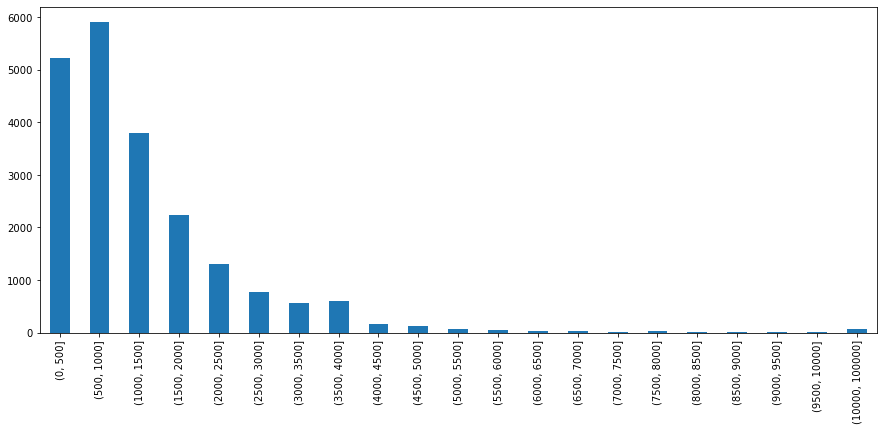

In [288]:
plt.figure(fdf_cleane=(15,6))
bins = list(np.arange(0, 10500, 500))
bins.append(100000)
pd.cut(df_clean['complaint_what_happened'].str.len(), bins=bins).value_counts(sort=False).plot(kind='bar')
plt.show()

#### Observation
- Majority of the complaints are below 4000 characters
- Most common complaint length is 500-1000 characters long

### WordCloug with top 40 words by frequency of occurence

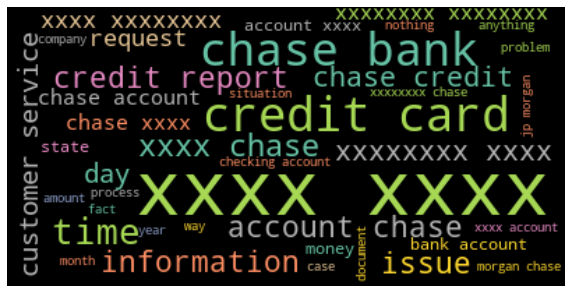

In [30]:
from wordcloud import WordCloud, STOPWORDS
text = " ".join(complaint for complaint in df_clean.nouns)

wordcloud = WordCloud(max_words=40, background_color='black', colormap='Set2', stopwords=STOPWORDS).generate(text)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [44]:
text = " ".join(df_clean['nouns'].tolist())
tokens = nltk.word_tokenize(text)

In [52]:
tokens[0:5]

['morning', 'name', 'xxxx', 'stop', 'bank']

#### Top 30 Unigrams

In [62]:
unigrams = ngrams(tokens,1)
unigrams_list = list(Counter(unigrams).most_common(30))

In [63]:
unigrams_list

[(('xxxx',), 134113),
 (('chase',), 72496),
 (('account',), 47706),
 (('credit',), 33485),
 (('card',), 30425),
 (('bank',), 28098),
 (('xxxxxxxx',), 27628),
 (('payment',), 21085),
 (('time',), 15995),
 (('charge',), 14063),
 (('day',), 12899),
 (('money',), 11900),
 (('check',), 11374),
 (('loan',), 10950),
 (('information',), 9624),
 (('letter',), 9602),
 (('call',), 9062),
 (('fee',), 8924),
 (('report',), 8808),
 (('transaction',), 8628),
 (('number',), 8596),
 (('month',), 8443),
 (('amount',), 8403),
 (('year',), 8257),
 (('mortgage',), 8152),
 (('customer',), 8145),
 (('balance',), 7771),
 (('service',), 7715),
 (('phone',), 7610),
 (('company',), 7584)]

#### Top 10 words in unigram by frequency

In [65]:
for word in unigrams_list[0:10]:
    print(word[0][0])

xxxx
chase
account
credit
card
bank
xxxxxxxx
payment
time
charge


#### Top 30 Bigrams
- printing 10 bigrams from top 30

In [69]:
bigrams = ngrams(tokens,2)
bigrams_list = list(Counter(bigrams).most_common(30))
print(bigrams_list)

[(('xxxx', 'xxxx'), 58042), (('credit', 'card'), 12839), (('chase', 'bank'), 12116), (('xxxx', 'chase'), 4680), (('credit', 'report'), 3941), (('account', 'chase'), 3806), (('xxxxxxxx', 'xxxx'), 3380), (('chase', 'credit'), 3348), (('customer', 'service'), 3080), (('xxxx', 'xxxxxxxx'), 2938), (('xxxxxxxx', 'xxxxxxxx'), 2803), (('chase', 'xxxx'), 2767), (('chase', 'account'), 2727), (('bank', 'account'), 2718), (('account', 'xxxx'), 2707), (('checking', 'account'), 2606), (('jp', 'morgan'), 2465), (('morgan', 'chase'), 2463), (('xxxxxxxx', 'chase'), 2226), (('xxxx', 'account'), 2224), (('debit', 'card'), 2022), (('account', 'account'), 1959), (('card', 'chase'), 1873), (('chase', 'card'), 1722), (('bank', 'xxxx'), 1710), (('credit', 'score'), 1707), (('number', 'xxxx'), 1659), (('phone', 'call'), 1639), (('xxxx', 'credit'), 1592), (('card', 'account'), 1569)]


In [73]:
for word in bigrams_list[0:10]:
    print(word[0][0], "|", word[0][1])

xxxx | xxxx
credit | card
chase | bank
xxxx | chase
credit | report
account | chase
xxxxxxxx | xxxx
chase | credit
customer | service
xxxx | xxxxxxxx


#### Top 30 Trigrams
- printing 10 Trigrams from top 30

In [74]:
trigrams = ngrams(tokens,3)
trigrams_list = list(Counter(trigrams).most_common(30))
print(trigrams_list)

[(('xxxx', 'xxxx', 'xxxx'), 29176), (('chase', 'credit', 'card'), 2356), (('jp', 'morgan', 'chase'), 2080), (('xxxx', 'xxxx', 'chase'), 1741), (('xxxxxxxx', 'xxxx', 'xxxx'), 1549), (('xxxx', 'xxxx', 'xxxxxxxx'), 1280), (('credit', 'card', 'account'), 1030), (('credit', 'card', 'company'), 975), (('_', '_', '_'), 951), (('chase', 'xxxx', 'xxxx'), 943), (('account', 'xxxx', 'xxxx'), 934), (('xxxx', 'xxxxxxxx', 'xxxx'), 933), (('credit', 'card', 'chase'), 925), (('chase', 'bank', 'xxxx'), 920), (('account', 'chase', 'bank'), 894), (('xxxx', 'chase', 'bank'), 866), (('bank', 'xxxx', 'xxxx'), 826), (('xxxx', 'xxxx', 'account'), 804), (('chase', 'bank', 'account'), 787), (('xxxx', 'credit', 'card'), 751), (('xxxxxxxx', 'xxxxxxxx', 'xxxxxxxx'), 716), (('morgan', 'chase', 'bank'), 677), (('name', 'xxxx', 'xxxx'), 607), (('xxxx', 'xxxx', 'credit'), 554), (('credit', 'card', 'xxxx'), 530), (('card', 'xxxx', 'xxxx'), 507), (('inquiry', 'credit', 'report'), 493), (('payment', 'xxxx', 'xxxx'), 483)

In [75]:
for word in trigrams_list[0:10]:
    print(word[0][0], "|", word[0][1], "|", word[0][2])

xxxx | xxxx | xxxx
chase | credit | card
jp | morgan | chase
xxxx | xxxx | chase
xxxxxxxx | xxxx | xxxx
xxxx | xxxx | xxxxxxxx
credit | card | account
credit | card | company
_ | _ | _
chase | xxxx | xxxx


In [78]:
#for row in df_clean['complaint']:
#    if "_" in row:
#        print(row)

---
#### The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [110]:
def remove_masking_characters(inp):
    # remove _+
    # remove xx+
    inp = inp.lower()
    inp = re.sub(r"_+", "", inp).strip()
    inp = re.sub(r"xx+", "", inp).strip()
    inp = re.sub(r"\s+", " ", inp).strip()
    
    return inp

In [111]:
df_clean['nouns'][171]

'complaint filing sustain bank accuse wrongdoing _ _ _ _ _ xxxx xxxx _ _ _ _ _ _ _ _ _ _ _ _ xxxx xxxx xxxx _ _ _ _ _ xxxx xxxx va xxxx _ _ _ complaint notice retaliation discrimination date chase bank act retaliation person transaction ability account end account number show copy statement reject date copy complaint term condition account obligation bank way bank action filing cfpb bank cfpb access complaint rejection write bank attempt arbitration complaint bank behavior person chase bank chase card service company chase business name us act consumer protrction act reform cfpa credit opportunity act act law regulation provision prohibit retaliation discrimination consumer anyone company cfpb regulator receipt decline purchase chase bank chase law term aggression action bank consequence bank _ bank act action retaliation type matter bank aggression type harm action action time notice kind bank moment credit limit e state herein state belief knowledge understanding change correction ki

In [112]:
df_clean['nouns'].apply(remove_masking_characters)[171]

'complaint filing sustain bank accuse wrongdoing va complaint notice retaliation discrimination date chase bank act retaliation person transaction ability account end account number show copy statement reject date copy complaint term condition account obligation bank way bank action filing cfpb bank cfpb access complaint rejection write bank attempt arbitration complaint bank behavior person chase bank chase card service company chase business name us act consumer protrction act reform cfpa credit opportunity act act law regulation provision prohibit retaliation discrimination consumer anyone company cfpb regulator receipt decline purchase chase bank chase law term aggression action bank consequence bank bank act action retaliation type matter bank aggression type harm action action time notice kind bank moment credit limit e state herein state belief knowledge understanding change correction kind time person counsel notice waive today'

In [113]:
# df_clean[df_clean['nouns'].str.contains('_', regex=True)]['nouns']

In [115]:
df_clean['nouns'] = df_clean['nouns'].apply(remove_masking_characters)

In [116]:
# all masked texts has been removed
df_clean.head(2)

,complaint,lemmatized_complaint,nouns
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service debt...
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent anniversary date agent information ...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [166]:
#Write your code here to initialise the TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [176]:
vect = TfidfVectorizer(stop_words='english')
X = vect.fit_transform(df_clean['lemmatized_complaint'])

dtm = pd.DataFrame(X.toarray(), columns=vect.get_feature_names())

MemoryError: Unable to allocate 5.47 GiB for an array with shape (21072, 34839) and data type float64

In [169]:
dtm.head(2)

,aa,aaa,aaaratings,aaccounts,aacount,aaid,aall,aand,aaoa,aare,...,zipcodeaddress,zipped,zombie,zone,zoned,zones,zoo,zoom,zoomed,zthe
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [171]:
from sklearn.decomposition import NMF

N_TOPICS = 15
nmf = NMF(n_components=N_TOPICS, init='nndsvd')
W = nmf.fit_transform(X)  # Document-topic matrix
H = nmf.components_       # Topic-term matrix

In [172]:
words = np.array(vect.get_feature_names())
topic_words = pd.DataFrame(np.zeros((N_TOPICS, 10)), index=[f'Topic {i + 1}' for i in range(N_TOPICS)],
                           columns=[f'Word {i + 1}' for i in range(10)]).astype(str)
for i in range(N_TOPICS):
    ix = H[i].argsort()[::-1][:10]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 1,xxxx,number,xxxxxxxxxxxx,address,complaint,office,chase,debt,case,contact
Topic 2,account,closed,checking,accounts,chase,opened,open,close,savings,reason
Topic 3,card,credit,chase,cards,score,limit,closed,accounts,applied,amazon
Topic 4,loan,mortgage,chase,modification,home,property,foreclosure,payments,years,rate
Topic 5,dispute,charge,chase,merchant,letter,received,refund,information,provided,sent
Topic 6,xxxxxxxx,received,letter,date,chase,called,told,dated,dates,statement
Topic 7,payment,late,payments,month,auto,chase,make,credit,pay,paid
Topic 8,check,funds,deposited,deposit,checks,cashed,cleared,hold,cash,days
Topic 9,charges,fraud,fraudulent,transactions,claim,card,transaction,debit,unauthorized,chase
Topic 10,fee,fees,overdraft,charged,annual,charge,insufficient,transactions,account,late


In [175]:
# Load your nmf_model with the n_components i.e 5
num_topics = 10

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, init='nndsvd', random_state=40)

In [177]:
dtm = df
nmf_model.fit(dtm)
len(nmf_model.get_feature_names())

MemoryError: Unable to allocate 5.47 GiB for an array with shape (21072, 34839) and data type float64

In [ ]:
#Print the Top15 words for each of the topics


In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4



In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = #write your code to assign topics to each rows.

In [ ]:
df_clean.head()

In [ ]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
#Create the dictionary of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Create the dictionary again of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=

In [ ]:
training_data

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count


#Write your code here to transform the word vector to tf-idf

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics





# References

- https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-a-column-in-pandas-dataframe
- https://www.kite.com/python/answers/how-to-use-regular-expressions-to-remove-text-within-parentheses-in-python
- https://stackoverflow.com/questions/18082130/python-regex-to-remove-all-words-which-contains-number
- https://spacy.io/api/lemmatizer
- https://stackoverflow.com/questions/47087741/use-tqdm-progress-bar-with-pandas
- https://spacy.io/usage/processing-pipelines
- https://spacy.io/usage/processing-pipelines#disabling